In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Feature Importance without Any Ranking Introduced

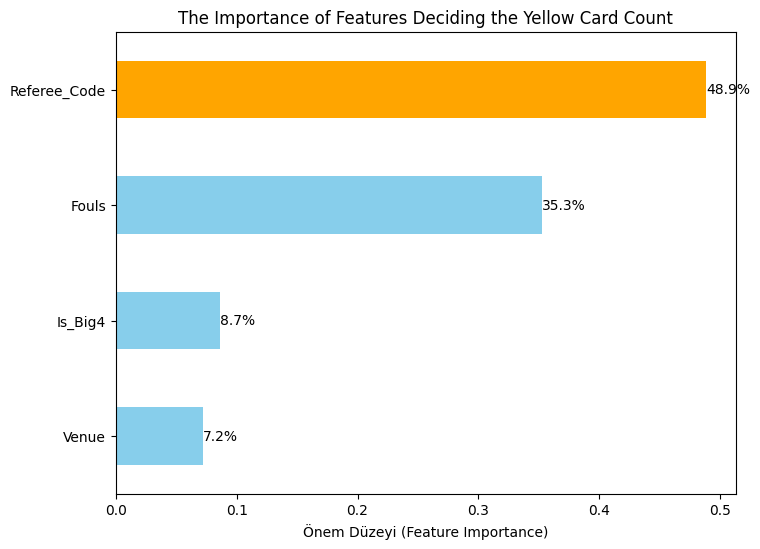

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# 1. Veri Hazırlığı
df = pd.read_csv('TURKISH_SUPER_LIG_FULL_DATASET_WITH_RANKS.csv') # Changed filename here
# Sadece analiz edilecek sütunları ve dolu verileri alalım
data = df[['HomeTeam', 'AwayTeam', 'HF', 'AF', 'HY', 'AY', 'Referee', 'Home_is_Big4', 'Away_is_Big4']].dropna()

# Veriyi Maç başına değil Takım başına performansa çevirelim (Satır sayısını 2 katına çıkarır, veri artar)
# Ev sahibi verisi
home_data = data[['HomeTeam', 'HF', 'HY', 'Referee', 'Home_is_Big4']].rename(
    columns={'HomeTeam': 'Team', 'HF': 'Fouls', 'HY': 'YellowCards', 'Home_is_Big4': 'Is_Big4'}
)
home_data['Venue'] = 1 # Home

# Deplasman verisi
away_data = data[['AwayTeam', 'AF', 'AY', 'Referee', 'Away_is_Big4']].rename(
    columns={'AwayTeam': 'Team', 'AF': 'Fouls', 'AY': 'YellowCards', 'Away_is_Big4': 'Is_Big4'}
)
away_data['Venue'] = 0 # Away

# Birleştir
ml_data = pd.concat([home_data, away_data], ignore_index=True)

# 2. Encoding (Hakem isimlerini sayıya çevirme)
le = LabelEncoder()
ml_data['Referee_Code'] = le.fit_transform(ml_data['Referee'])

# 3. Model Kurulumu
# Hedef: Sarı Kart Sayısını Tahmin Etmek
# Girdiler: Faul Sayısı, İç Saha/Dış Saha, Hakem Kimliği, TAKIM BÜYÜK MÜ?
X = ml_data[['Fouls', 'Venue', 'Referee_Code', 'Is_Big4']]
y = ml_data['YellowCards']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Feature Importance (Hangi özellik kart sayısını daha çok etkiliyor?)
importances = rf_model.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names)

# Görselleştirme
plt.figure(figsize=(8, 6))
colors = ['skyblue' if x != 'Is_Big4' else 'orange' for x in feature_names] # Renkler daha canlı hale getirildi
sorted_importances = forest_importances.sort_values(ascending=True)
ax = sorted_importances.plot(kind='barh', color=colors)
plt.title("The Importance of Features Deciding the Yellow Card Count")
plt.xlabel("Önem Düzeyi (Feature Importance)")

# Add feature importance values on the bars
for index, value in enumerate(sorted_importances):
    plt.text(value, index, f'{value*100:.1f}%', va='center', ha='left') # va for vertical alignment, ha for horizontal alignment.

plt.show()

# Eğer 'Is_Big4' özelliği 'Venue' veya 'Referee_Code' kadar önemli çıkarsa,
# bu takımın isminin kart görme üzerinde etkisi olduğunu kanıtlar.

# OLS Regression: Tolerance vs. Pressure Anlaysis( Big4 vs. Anadolu)

✅ Veri Seti Yüklendi. Toplam Maç: 2162


<Figure size 1000x600 with 0 Axes>

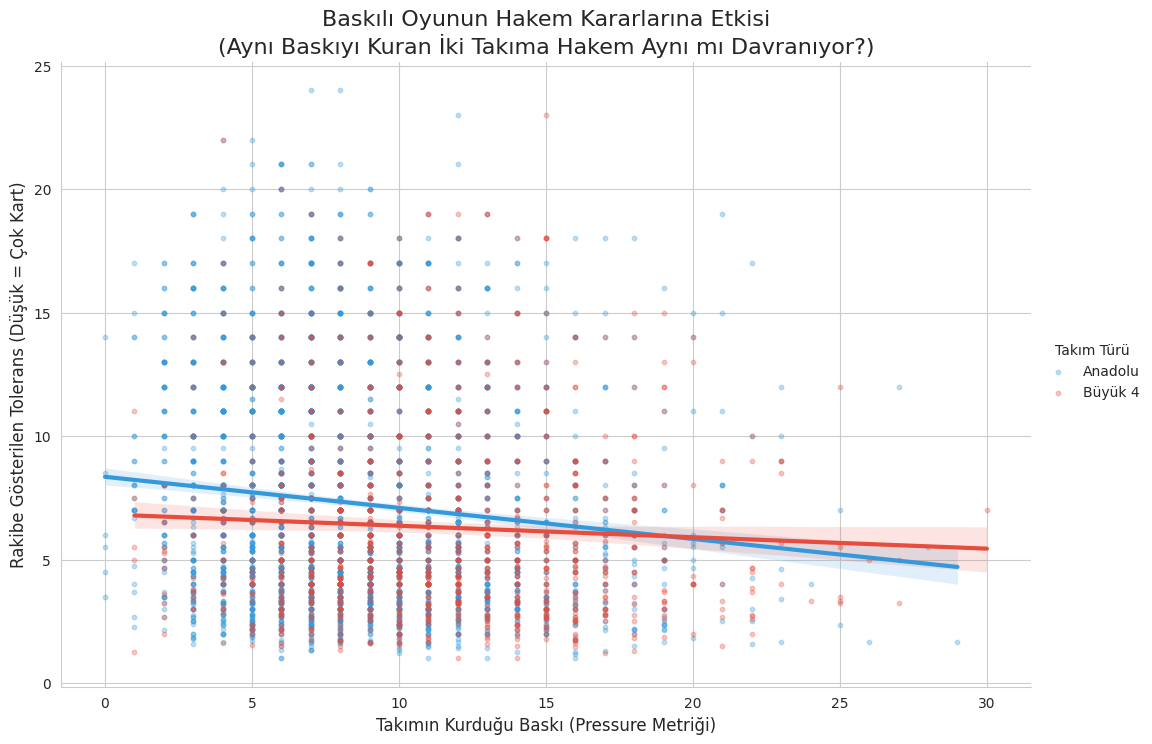

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# VERİYİ YÜKLE
try:
    df = pd.read_csv("TURKISH_SUPER_LIG_FULL_DATASET.csv")
    print(f"✅ Veri Seti Yüklendi. Toplam Maç: {len(df)}")
except FileNotFoundError:
    print("❌ Hata: 'TURKISH_SUPER_LIG_FULL_DATASET.csv' dosyası bulunamadı.")
    exit()

# 1. VERİYİ HAZIRLA
# Ev sahibi baskı kurduğunda -> Deplasmanın Toleransı ne oldu?
home_pressure_df = df[['Season', 'Home_is_Big4', 'Home_Pressure', 'Away_Foul_Tolerance']].copy()
home_pressure_df.columns = ['Season', 'Is_Big4', 'Pressure', 'Opponent_Tolerance']

# Deplasman baskı kurduğunda -> Ev sahibinin Toleransı ne oldu?
away_pressure_df = df[['Season', 'Away_is_Big4', 'Away_Pressure', 'Home_Foul_Tolerance']].copy()
away_pressure_df.columns = ['Season', 'Is_Big4', 'Pressure', 'Opponent_Tolerance']

# İkisini alt alta ekle (Bütün baskı anlarını tek havuz yapıyoruz)
pressure_analysis_df = pd.concat([home_pressure_df, away_pressure_df], ignore_index=True)

# Temizlik ve Etiketleme
pressure_analysis_df = pressure_analysis_df.dropna()
pressure_analysis_df = pressure_analysis_df[pressure_analysis_df['Opponent_Tolerance'] < 25] # Uç değer temizliği
pressure_analysis_df['Takım Türü'] = pressure_analysis_df['Is_Big4'].map({1: 'Büyük 4', 0: 'Anadolu'})

# 2. GÖRSELLEŞTİRME (LM Plot - Regresyon Analizi)
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Bu grafik şunu gösterir: Baskı arttıkça (X ekseni sağa gittikçe),
# Rakibin toleransı (Y ekseni) ne kadar hızlı düşüyor?
sns.lmplot(
    data=pressure_analysis_df,
    x='Pressure',
    y='Opponent_Tolerance',
    hue='Takım Türü',
    palette=['#3498db', '#e74c3c'], # Mavi (Anadolu), Kırmızı (Big4)
    height=7,
    aspect=1.5,
    scatter_kws={'alpha': 0.3, 's': 10}, # Noktaları biraz silik yap ki doğrular öne çıksın
    line_kws={'linewidth': 3}
)

plt.title('Baskılı Oyunun Hakem Kararlarına Etkisi\n(Aynı Baskıyı Kuran İki Takıma Hakem Aynı mı Davranıyor?)', fontsize=16)
plt.xlabel('Takımın Kurduğu Baskı (Pressure Metriği)', fontsize=12)
plt.ylabel('Rakibe Gösterilen Tolerans (Düşük = Çok Kart)', fontsize=12)

plt.show()

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1. VERİYİ HAZIRLA (Üstteki koddan gelen dataframe: pressure_analysis_df)
# Is_Big4 zaten 0 ve 1 (Anadolu=0, Big4=1) olduğu için işimiz kolay.
# Formülümüz şu: Tolerance = a + b1*Pressure + b2*Is_Big4 + b3*(Pressure * Is_Big4)

# 2. MODELİ KUR (OLS: Ordinary Least Squares)
# 'Pressure:Is_Big4' ifadesi etkileşim terimidir (Interaction Term)
model = smf.ols(formula='Opponent_Tolerance ~ Pressure * Is_Big4', data=pressure_analysis_df).fit()

# 3. SONUCU YAZDIR
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     Opponent_Tolerance   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     30.62
Date:                Tue, 06 Jan 2026   Prob (F-statistic):           1.39e-19
Time:                        22:48:12   Log-Likelihood:                -12239.
No. Observations:                4323   AIC:                         2.449e+04
Df Residuals:                    4319   BIC:                         2.451e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.3487      0.174  

# Feature Importance with Current Rankings


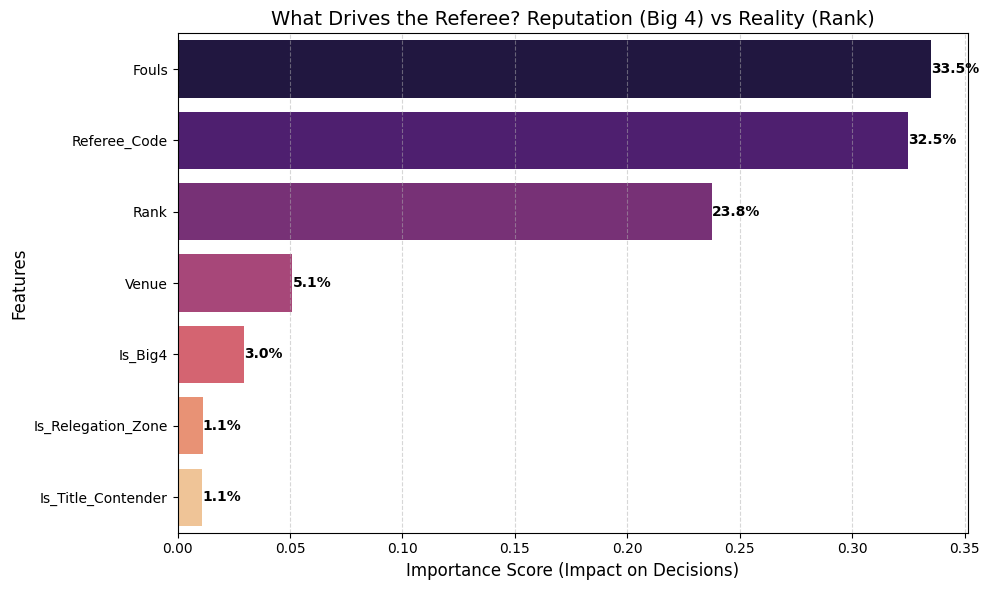


--- ADVANCED MODEL RESULTS ---
           Feature  Importance
             Fouls    0.334888
      Referee_Code    0.324859
              Rank    0.237605
             Venue    0.051052
           Is_Big4    0.029546
Is_Relegation_Zone    0.011119
Is_Title_Contender    0.010930


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Hazır Dosyayı Yükle
# (Bu dosyanın içinde sıralamaların hazır olduğunu biliyoruz)
df = pd.read_csv('TURKISH_SUPER_LIG_FULL_DATASET_WITH_RANKS.csv')

# 2. Veri Hazırlığı
# Sadece sıralamanın olduğu (2. yarı) maçları al
df_ml = df.dropna(subset=['Home_Rank', 'Away_Rank']).copy()

# Ev Sahibi Verisi
home_df = df_ml[['HomeTeam', 'HF', 'HY', 'Referee', 'Home_is_Big4', 'Home_Rank']].rename(
    columns={'HomeTeam': 'Team', 'HF': 'Fouls', 'HY': 'YellowCards', 'Home_is_Big4': 'Is_Big4', 'Home_Rank': 'Rank'}
)
home_df['Venue'] = 1 # Ev Sahibi

# Deplasman Verisi
away_df = df_ml[['AwayTeam', 'AF', 'AY', 'Referee', 'Away_is_Big4', 'Away_Rank']].rename(
    columns={'AwayTeam': 'Team', 'AF': 'Fouls', 'AY': 'YellowCards', 'Away_is_Big4': 'Is_Big4', 'Away_Rank': 'Rank'}
)
away_df['Venue'] = 0 # Deplasman

# Birleştir
model_data = pd.concat([home_df, away_df], ignore_index=True)

# 3. Encoding (Hakem İsimlerini Sayıya Çevirme)
le = LabelEncoder()
model_data['Referee_Code'] = le.fit_transform(model_data['Referee'])

# 4. Feature Engineering (Yeni Özellikler)
# Sıralamaya göre "Baskı Bölgeleri" oluşturuyoruz
model_data['Is_Title_Contender'] = (model_data['Rank'] <= 3).astype(int)   # İlk 3 (Şampiyonluk Yarışı)
model_data['Is_Relegation_Zone'] = (model_data['Rank'] >= 16).astype(int)  # Son 4 (Düşme Hattı)

# 5. Random Forest Modeli
# Soru: Kart sayısını tahmin ederken 'İsim' (Big4) mi daha önemli, 'Sıra' (Rank) mı?
X = model_data[['Fouls', 'Venue', 'Referee_Code', 'Is_Big4', 'Rank', 'Is_Title_Contender', 'Is_Relegation_Zone']]
y = model_data['YellowCards']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X, y)

# 6. Sonuçları Görselleştirme (Feature Importance)
importances = rf_model.feature_importances_
feature_names = X.columns
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)

# Grafik (İngilizce)
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='magma')
plt.title('What Drives the Referee? Reputation (Big 4) vs Reality (Rank)', fontsize=14)
plt.xlabel('Importance Score (Impact on Decisions)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)

# Yüzdeleri çubukların ucuna yazalım
for index, value in enumerate(feat_imp['Importance']):
    plt.text(value, index, f'{value*100:.1f}%', va='center', fontsize=10, weight='bold')

plt.tight_layout()
plt.savefig('rank_vs_reputation_impact.png')
plt.show()

# 7. Konsol Çıktısı
print("\n--- ADVANCED MODEL RESULTS ---")
print(feat_imp.to_string(index=False))

# Referee Istatistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ==========================================
# BÖLÜM 1: HAKEM KARAKTERİSTİKLERİNİ ÇIKARMA
# ==========================================

# 1. Veriyi Yükle
df = pd.read_csv('TURKISH_SUPER_LIG_FULL_DATASET_WITH_RANKS.csv')

# 2. Veriyi "Maç Bazlı"dan "Takım Bazlı"ya Çevir (Long Format)
# Ev sahibi ve Deplasman istatistiklerini alt alta ekliyoruz
home_stats = df[['Referee', 'HF', 'HY', 'Home_is_Big4']].rename(
    columns={'HF': 'Fouls', 'HY': 'YellowCards', 'Home_is_Big4': 'Is_Big4'}
)
away_stats = df[['Referee', 'AF', 'AY', 'Away_is_Big4']].rename(
    columns={'AF': 'Fouls', 'AY': 'YellowCards', 'Away_is_Big4': 'Is_Big4'}
)
all_stats = pd.concat([home_stats, away_stats], ignore_index=True)

# 3. Her Hakem İçin Metrikleri Hesapla
# a) Genel İstatistikler
ref_agg = all_stats.groupby('Referee').agg(
    Matches=('Referee', 'count'),          # Toplam Maç Sayısı (Aslında takım sayısı, /2 yapılabilir ama oran değişmez)
    Total_Fouls=('Fouls', 'sum'),
    Total_Cards=('YellowCards', 'sum')
)
# Genel Tolerans (Faul / Kart)
ref_agg['General_Tolerance'] = ref_agg['Total_Fouls'] / ref_agg['Total_Cards'].replace(0, 1)
# Sertlik (Maç Başına Kart) - Buradaki 'Matches' takım katılımı olduğu için /2 mantığıyla yaklaşabiliriz veya direkt oranlarız.
# Not: Bir maçta 2 satır var (Home+Away). O yüzden gerçek maç sayısı = Matches / 2
ref_agg['Avg_Cards_Per_Match'] = (ref_agg['Total_Cards'] / ref_agg['Matches']) * 2

# b) Bias Score (Ayrımcılık Puanı) Hesaplama
# Big 4 Maçlarındaki Performans
big4_stats = all_stats[all_stats['Is_Big4'] == 1].groupby('Referee').agg(
    Big4_Fouls=('Fouls', 'sum'),
    Big4_Cards=('YellowCards', 'sum')
)
big4_stats['Tol_Big4'] = big4_stats['Big4_Fouls'] / big4_stats['Big4_Cards'].replace(0, 1)

# Anadolu Maçlarındaki Performans
others_stats = all_stats[all_stats['Is_Big4'] == 0].groupby('Referee').agg(
    Others_Fouls=('Fouls', 'sum'),
    Others_Cards=('YellowCards', 'sum')
)
others_stats['Tol_Others'] = others_stats['Others_Fouls'] / others_stats['Others_Cards'].replace(0, 1)

# Tabloları Birleştir
ref_summary = ref_agg.join(big4_stats[['Tol_Big4']]).join(others_stats[['Tol_Others']])

# *** BIAS SCORE FORMÜLÜ ***
ref_summary['Bias_Score'] = ref_summary['Tol_Big4'] - ref_summary['Tol_Others']

# 4. Filtreleme (Güvenilirlik İçin)
# En az 20 maça (yani veride 40 satıra) çıkmış hakemleri alalım.
# Az maç yönetenler istatistiği bozar (Outlier).
min_match_rows = 40
ref_final = ref_summary[ref_summary['Matches'] >= min_match_rows].dropna().copy()

# Reset index to make 'Referee' a column before saving
ref_final = ref_final.reset_index()

print("--- HAKEM KARAKTERİSTİKLERİ HAZIRLANDI ---")
print(ref_final[['Referee', 'Matches', 'Avg_Cards_Per_Match', 'Bias_Score']].head()) # Also print Referee column

# Save to CSV with utf-8-sig encoding
ref_final.to_csv('hakem_karakteristikleri.csv', encoding='utf-8-sig', index=False)
print("Hakem karakteristikleri 'hakem_karakteristikleri.csv' dosyasına kaydedildi.")

--- HAKEM KARAKTERİSTİKLERİ HAZIRLANDI ---
              Referee  Matches  Avg_Cards_Per_Match  Bias_Score
0  Abdulkadir Bitigen      144             5.166667    1.155039
1       Ali Palabıyık      160             5.125000   -1.137092
2        Ali Şansalan      184             4.793478    0.074761
3        Alper Ulusoy      122             4.704918   -0.873733
4      Arda Kardeşler      200             4.260000    0.159201
Hakem karakteristikleri 'hakem_karakteristikleri.csv' dosyasına kaydedildi.


Hakem Verisi: (35, 9)
Maç Verisi: (2162, 34)

--- HAKEM KÜMELEME SONUÇLARI ---
              Referee            Referee_Profile  Bias_Score
0  Abdulkadir Bitigen    Strict (Disciplinarian)    1.155039
1       Ali Palabıyık    Strict (Disciplinarian)   -1.137092
2        Ali Şansalan    Strict (Disciplinarian)    0.074761
3        Alper Ulusoy    Strict (Disciplinarian)   -0.873733
4      Arda Kardeşler        Balanced (Standard)    0.159201
5    Atilla Karaoğlan    Strict (Disciplinarian)    0.107790
6     Bahattin Şimşek  Red Zone (Big 4 Friendly)    3.090024
7        Burak Pakkan    Strict (Disciplinarian)   -0.782805
8         Burak Şeker    Strict (Disciplinarian)    1.737864
9         Cihan Aydın  Red Zone (Big 4 Friendly)    1.693207

Dosya oluşturuldu: 'TURKISH_SUPER_LIG_FINAL_CLUSTERED.csv'


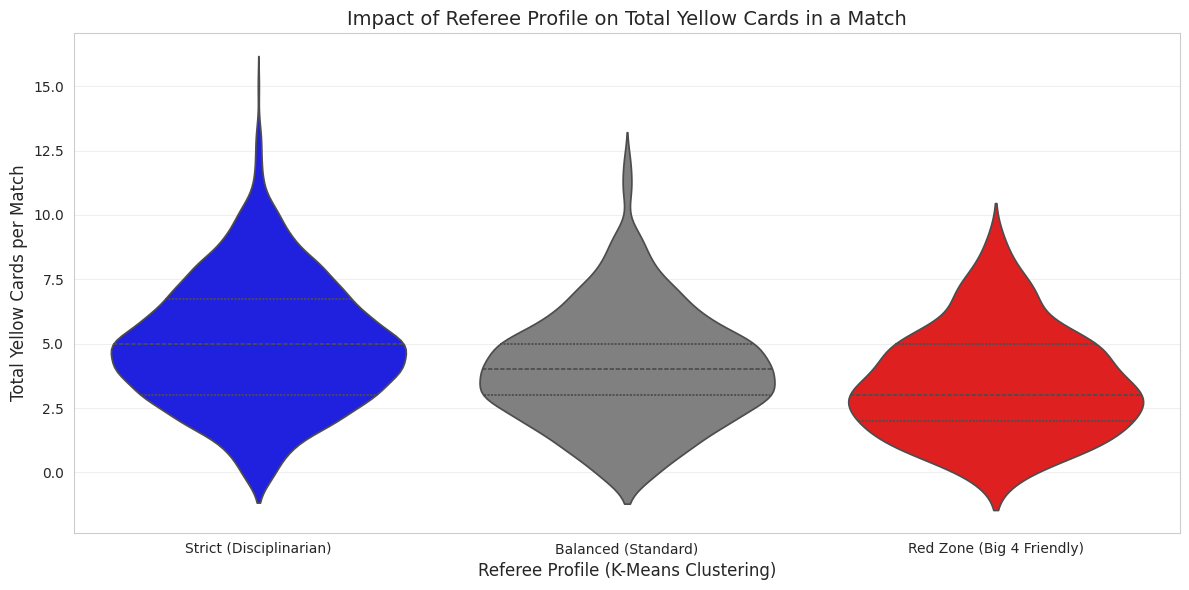

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ======================================================
# ADIM 1: DOSYALARI YÜKLEME
# ======================================================
# Elindeki iki dosyayı yüklüyoruz
ref_df = pd.read_csv('hakem_karakteristikleri.csv')  # Corrected filename: Hakem Karnesi (Bias Score vb. olan)
match_df = pd.read_csv('TURKISH_SUPER_LIG_FULL_DATASET_WITH_RANKS.csv') # Maç verisi

print(f"Hakem Verisi: {ref_df.shape}")
print(f"Maç Verisi: {match_df.shape}")

# ======================================================
# ADIM 2: K-MEANS CLUSTERING (KÜMELEME)
# ======================================================
# Hakemleri karakterlerine göre 3 gruba ayıracağız.
# Kullanacağımız Özellikler:
# 1. Avg_Cards_Per_Match: Hakem ne kadar kart gösteriyor? (Sertlik)
# 2. Bias_Score: Büyük takımlara toleransı ne kadar farklı? (Yanlılık)
# 3. General_Tolerance: Faul/Kart oranı.

features = ['Avg_Cards_Per_Match', 'Bias_Score', 'General_Tolerance']

# Veriyi hazırlayalım (Eksik veri varsa uçuralım)
X = ref_df[features].dropna()

# Ölçeklendirme (Scaling - W9):
# Bias 1.5 iken Kart Ortalaması 5.0 olabilir. Biri diğerini ezmesin diye standartlaştırıyoruz.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means Modeli (k=3) -> (Friendly, Strict, Standard)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
ref_df.loc[X.index, 'Cluster_ID'] = kmeans.fit_predict(X_scaled)

# ======================================================
# ADIM 3: KÜMELERİ İSİMLENDİRME (ETİKETLEME)
# ======================================================
# Matematiksel ID (0,1,2) yerine onlara anlamlı isimler verelim.

# Her kümenin ortalamalarına bakalım
cluster_stats = ref_df.groupby('Cluster_ID')[['Bias_Score', 'Avg_Cards_Per_Match']].mean()

# Mantıksal Kurallar:
# En yüksek Bias Score -> "Red Zone (Big 4 Friendly)"
# En yüksek Kart Ortalaması -> "Strict / Disciplinarian"
# Geriye kalan -> "Balanced / Standard"

red_zone_id = cluster_stats['Bias_Score'].idxmax()
strict_id = cluster_stats['Avg_Cards_Per_Match'].idxmax()

def name_cluster(cluster_id):
    if cluster_id == red_zone_id:
        return 'Red Zone (Big 4 Friendly)'
    elif cluster_id == strict_id:
        return 'Strict (Disciplinarian)'
    else:
        return 'Balanced (Standard)'

ref_df['Referee_Profile'] = ref_df['Cluster_ID'].apply(name_cluster)

# Sonuçları görelim
print("\n--- HAKEM KÜMELEME SONUÇLARI ---")
print(ref_df[['Referee', 'Referee_Profile', 'Bias_Score']].head(10))

# ======================================================
# ADIM 4: VERİLERİ BİRLEŞTİRME (MERGING)
# ======================================================
# Şimdi bu "Profil" bilgisini ana maç verisine ekleyelim.
# Artık her maçın yanında o maçı yöneten hakemin "Karakteri" yazacak.

merged_df = match_df.merge(
    ref_df[['Referee', 'Referee_Profile', 'Cluster_ID']],
    on='Referee',
    how='left'
)

# Kaydetme
merged_df.to_csv('TURKISH_SUPER_LIG_FINAL_CLUSTERED.csv', index=False)
print("\nDosya oluşturuldu: 'TURKISH_SUPER_LIG_FINAL_CLUSTERED.csv'")

# ======================================================
# ADIM 5: GÖRSEL KANIT (BOXPLOT)
# ======================================================
# Bakalım "Strict" hakemler gerçekten daha çok kart göstermiş mi?

plt.figure(figsize=(12, 6))
# Toplam maç kartı (Ev + Dep)
merged_df['Total_Cards_In_Match'] = merged_df['HY'] + merged_df['AY']

sns.violinplot(
    data=merged_df,
    x='Referee_Profile',
    y='Total_Cards_In_Match',
    palette={'Red Zone (Big 4 Friendly)': 'red', 'Strict (Disciplinarian)': 'blue', 'Balanced (Standard)': 'gray'},
    inner='quartile'
)

plt.title('Impact of Referee Profile on Total Yellow Cards in a Match', fontsize=14)
plt.ylabel('Total Yellow Cards per Match', fontsize=12)
plt.xlabel('Referee Profile (K-Means Clustering)', fontsize=12)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('referee_profile_impact_on_cards.png')
plt.show()

# K-Means Clustering Visualization

Satır sayıları eşit, birleştiriliyor...


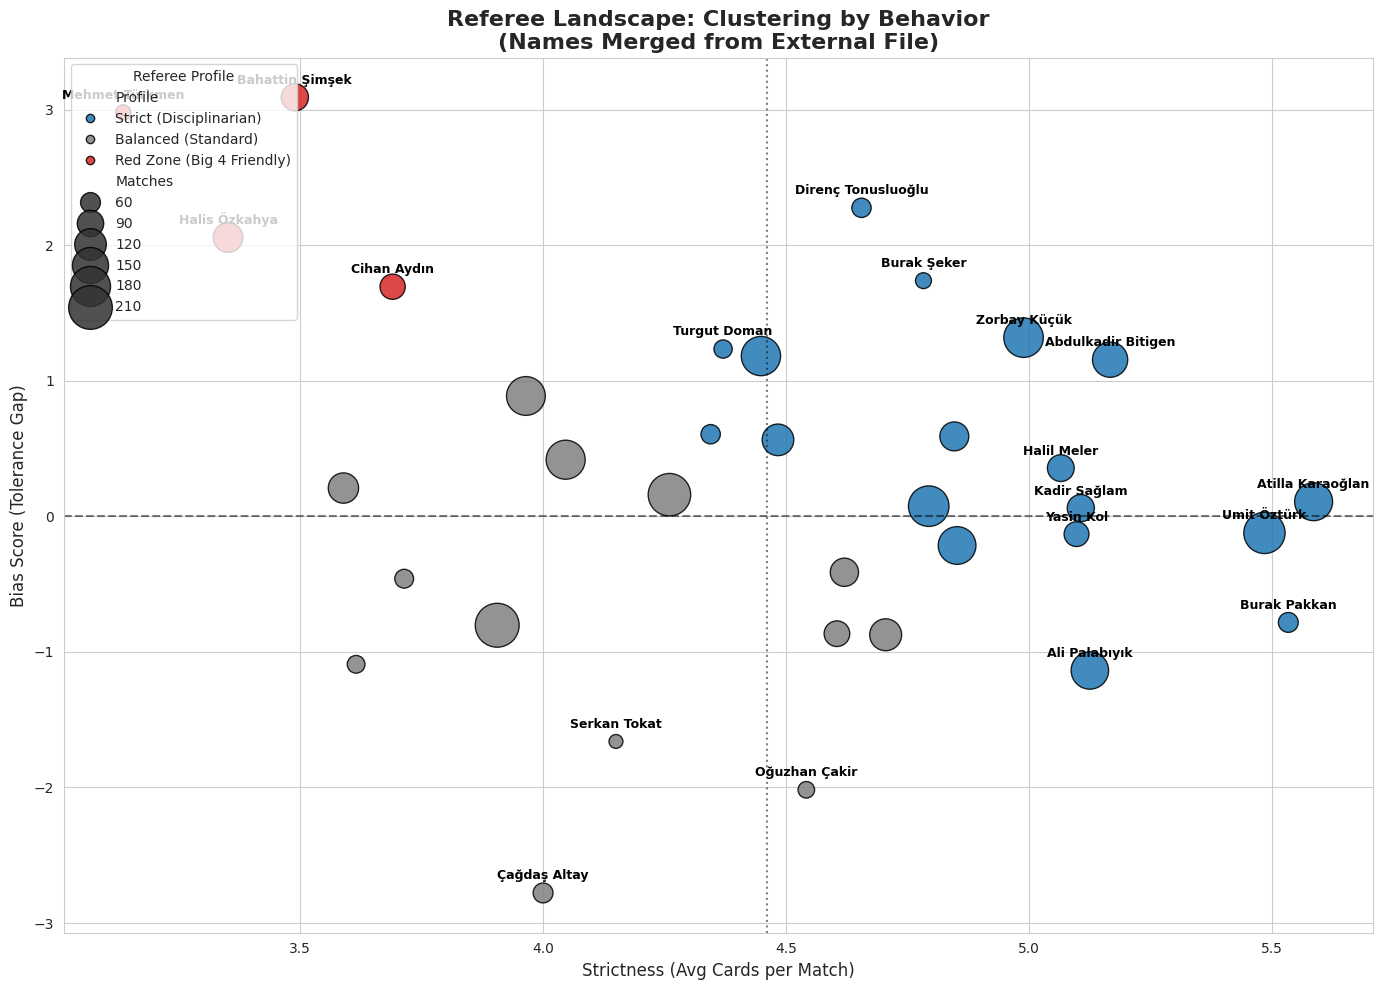

Grafik oluşturuldu: referee_landscape_merged.png


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ==========================================
# 1. DOSYALARI YÜKLEME VE BİRLEŞTİRME
# ==========================================

# A) İsimlerin olduğu dosyayı yükle
# "hakem_karakteristikleri.csv" dosyasında 'Referee' sütunu olduğunu varsayıyoruz.
df_names = pd.read_csv('hakem_karakteristikleri.csv')

# B) İsimsiz (Veri) dosyasını yükle
# KANKA DİKKAT: Buraya isimsiz dosyanın adını yazmalısın.
# Örn: 'referee_stats_no_name.csv' veya elindeki dosya neyse.
df_data = pd.read_csv('referee_characteristics.csv')

# Kontrol: Satır sayıları eşit mi?
if len(df_names) != len(df_data):
    print(f"UYARI: Dosyaların satır sayıları eşit değil! ({len(df_names)} vs {len(df_data)})")
    print("Sıralamanın kaymadığından emin ol.")
else:
    print("Satır sayıları eşit, birleştiriliyor...")

# C) İsimleri Veriye Yapıştır (Merge by Index)
# Sıra aynı olduğu için direkt sütunu kopyalıyoruz.
df_data['Referee'] = df_names['Referee'].values

# Eğer 'Matches' (Maç Sayısı) verisi isimli dosyadaysa onu da alalım
if 'Matches' in df_names.columns and 'Matches' not in df_data.columns:
    df_data['Matches'] = df_names['Matches'].values

# ==========================================
# 2. KÜMELEME (K-MEANS)
# ==========================================

# Analiz için gerekli sütunları seç (Dosyandaki isimler farklıysa düzelt)
# Genelde: 'Avg_Cards_Per_Match' ve 'Bias_Score' kullanırız.
features = ['Avg_Cards_Per_Match', 'Bias_Score']

# Veriyi hazırla
X = df_data[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modeli Çalıştır (3 Küme)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_data.loc[X.index, 'Cluster'] = kmeans.fit_predict(X_scaled)

# ==========================================
# 3. KÜMELERİ İSİMLENDİRME (OTOMATİK)
# ==========================================
cluster_means = df_data.groupby('Cluster')[['Bias_Score', 'Avg_Cards_Per_Match']].mean()

# Kümeleri Tanımla
red_zone_id = cluster_means['Bias_Score'].idxmax()       # En Yanlı
strict_id = cluster_means['Avg_Cards_Per_Match'].idxmax() # En Sert

def get_profile(c):
    if c == red_zone_id: return 'Red Zone (Big 4 Friendly)'
    elif c == strict_id: return 'Strict (Disciplinarian)'
    else: return 'Balanced (Standard)'

df_data['Profile'] = df_data['Cluster'].apply(get_profile)

# ==========================================
# 4. GÖRSELLEŞTİRME (LANDSCAPE)
# ==========================================
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

# Renkler
colors = {
    'Red Zone (Big 4 Friendly)': '#d62728', # Kırmızı
    'Strict (Disciplinarian)': '#1f77b4',   # Mavi
    'Balanced (Standard)': 'gray'           # Gri
}

# Çizim
scatter = sns.scatterplot(
    data=df_data,
    x='Avg_Cards_Per_Match',
    y='Bias_Score',
    hue='Profile',
    palette=colors,
    size='Matches' if 'Matches' in df_data.columns else None,
    sizes=(100, 1000),
    alpha=0.85,
    edgecolor='black'
)

# Çizgiler
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.axvline(df_data['Avg_Cards_Per_Match'].mean(), color='black', linestyle=':', alpha=0.5)

# İsimleri Yazdır (Önemli Hakemler)
for i in range(len(df_data)):
    row = df_data.iloc[i]
    # Sadece Red Zone veya Uç Değerleri Yaz
    if row['Profile'] == 'Red Zone (Big 4 Friendly)' or abs(row['Bias_Score']) > 1.2 or row['Avg_Cards_Per_Match'] > 5.0:
        plt.text(
            row['Avg_Cards_Per_Match'],
            row['Bias_Score'] + 0.1,
            row['Referee'],
            horizontalalignment='center',
            fontsize=9,
            weight='bold',
            color='black'
        )

plt.title('Referee Landscape: Clustering by Behavior\n(Names Merged from External File)', fontsize=16, weight='bold')
plt.xlabel('Strictness (Avg Cards per Match)', fontsize=12)
plt.ylabel('Bias Score (Tolerance Gap)', fontsize=12)
plt.legend(title='Referee Profile', loc='upper left')

plt.tight_layout()
plt.savefig('referee_landscape_merged.png')
plt.show()

print("Grafik oluşturuldu: referee_landscape_merged.png")

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 1. Verileri Yükle
# Maç verisi (Sıralamalar var)
df_match = pd.read_csv('TURKISH_SUPER_LIG_FULL_DATASET_WITH_RANKS.csv')
# Hakem karakteristiği (Sertlik ve Bias skorları var)
df_ref = pd.read_csv('hakem_karakteristikleri.csv')

# 2. Veriyi Birleştir (Merge)
# Her maçın yanına, o maçı yöneten hakemin özelliklerini (Sertlik, Bias) ekliyoruz.
# Bu sayede model "Ali Palabıyık" ismini değil, onun "Matematiksel Profilini" öğrenecek.
# df_ref dosyasındaki sütun adları: Referee, Avg_Cards_Per_Match, Bias_Score ...
df_merged = df_match.merge(df_ref[['Referee', 'Avg_Cards_Per_Match', 'Bias_Score']], on='Referee', how='left')

# Eksik verileri temizle (Hakem istatistiği olmayan maçlar vs.)
df_model = df_merged.dropna(subset=['Home_Rank', 'Away_Rank', 'Avg_Cards_Per_Match', 'Bias_Score']).copy()

# 3. Model İçin Veriyi Hazırla (Ev Sahibi ve Deplasman Perspektifi)
# Modeli "Takım Bazlı" kuruyoruz. Yani her satır "Bir Takımın O Maçtaki Kartı" olacak.

# Ev Sahibi Verisi
h_data = df_model[['Home_Rank', 'Home_is_Big4', 'Away_Rank', 'Away_is_Big4', 'Avg_Cards_Per_Match', 'Bias_Score', 'HY']].copy()
h_data['Venue'] = 1 # Ev Sahibi
h_data.columns = ['Rank', 'Is_Big4', 'Opp_Rank', 'Opp_Is_Big4', 'Ref_Strictness', 'Ref_Bias', 'Target_Cards', 'Venue']

# Deplasman Verisi
a_data = df_model[['Away_Rank', 'Away_is_Big4', 'Home_Rank', 'Home_is_Big4', 'Avg_Cards_Per_Match', 'Bias_Score', 'AY']].copy()
a_data['Venue'] = 0 # Deplasman
a_data.columns = ['Rank', 'Is_Big4', 'Opp_Rank', 'Opp_Is_Big4', 'Ref_Strictness', 'Ref_Bias', 'Target_Cards', 'Venue']

# İkisini alt alta ekle
train_data = pd.concat([h_data, a_data], ignore_index=True)

# 4. Modeli Eğit (Random Forest)
features = ['Rank', 'Is_Big4', 'Opp_Rank', 'Opp_Is_Big4', 'Ref_Strictness', 'Ref_Bias', 'Venue']
X = train_data[features]
y = train_data['Target_Cards']

# Modeli kuruyoruz (Derinliği sınırlı tutuyoruz ki aşırı ezberlemesin, genel kuralları öğrensin)
rf_engine = RandomForestRegressor(n_estimators=200, max_depth=7, random_state=42)
rf_engine.fit(X, y)

# 5. Kontrol Et
mae = mean_absolute_error(y, rf_engine.predict(X))
print(f"Simülasyon Motoru Hazır!")
print(f"Ortalama Hata Payı: {mae:.2f} Kart")
print("\nModelin Öğrendiği Mantık (Feature Importance):")
importances = pd.Series(rf_engine.feature_importances_, index=features).sort_values(ascending=False)
print(importances)

Simülasyon Motoru Hazır!
Ortalama Hata Payı: 1.01 Kart

Modelin Öğrendiği Mantık (Feature Importance):
Ref_Strictness    0.270879
Rank              0.232246
Opp_Rank          0.219113
Ref_Bias          0.133522
Opp_Is_Big4       0.083324
Venue             0.031095
Is_Big4           0.029820
dtype: float64


# Card Distribution

Card Statistics:
count    2162.000000
mean        4.572155
std         2.356010
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        15.000000
Name: Total_Yellow_Cards, dtype: float64


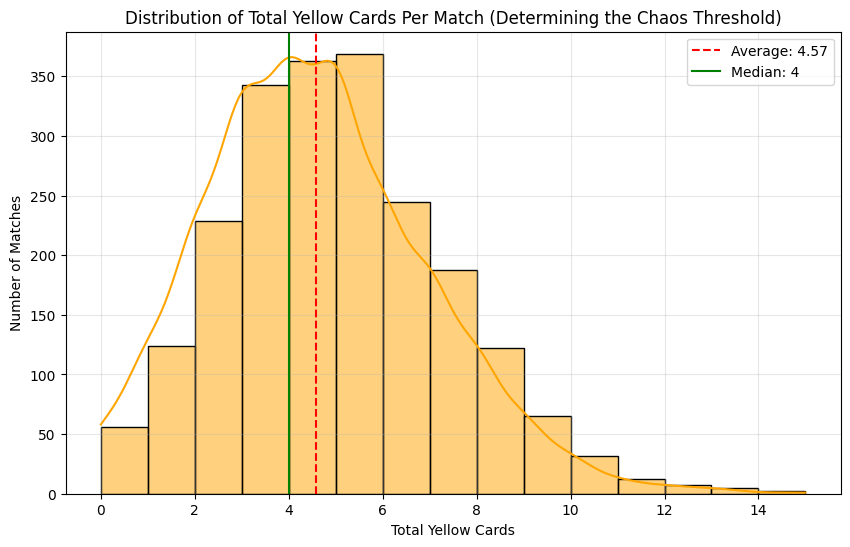

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
df = pd.read_csv('TURKISH_SUPER_LIG_FINAL_CLUSTERED.csv')

# 2. Calculate Total Yellow Card Count
# Check if HY/AY exist (column names might differ in some datasets).
# Previous snippets showed HY, AY are present.
df['Total_Yellow_Cards'] = df['HY'] + df['AY']

# 3. View Statistics
stats = df['Total_Yellow_Cards'].describe()
print("Card Statistics:")
print(stats)

# 4. Visualize Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Total_Yellow_Cards'], bins=15, kde=True, color='orange')
plt.axvline(stats['mean'], color='red', linestyle='--', label=f"Average: {stats['mean']:.2f}")
plt.axvline(stats['50%'], color='green', linestyle='-', label=f"Median: {stats['50%']:.0f}")
plt.title('Distribution of Total Yellow Cards Per Match (Determining the Chaos Threshold)')
plt.xlabel('Total Yellow Cards')
plt.ylabel('Number of Matches')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('card_distribution_chaos.png')
plt.show()


--- CHAOS PREDICTION MODEL RESULTS ---
Accuracy:  55.09%
Recall:    73.97%
Precision: 49.09%

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.40      0.50        94
           1       0.49      0.74      0.59        73

    accuracy                           0.55       167
   macro avg       0.58      0.57      0.55       167
weighted avg       0.59      0.55      0.54       167



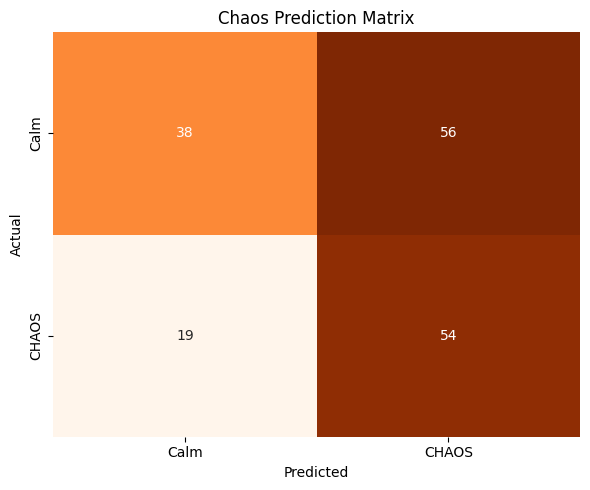

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# ==========================================
# 1. VERİ YÜKLEME VE HAZIRLIK
# ==========================================
# Kümelenmiş veriyi yükle (İçinde Referee_Profile var)
df = pd.read_csv('TURKISH_SUPER_LIG_FINAL_CLUSTERED.csv')

# Hedef Değişken: KAOS
# Bir maçta toplam kart sayısı 6'dan fazlaysa (7+) buna "Kaos" diyoruz.
df['Total_Cards'] = df['HY'] + df['AY']
df['Chaos'] = (df['Total_Cards'] > 6).astype(int)

# Girdileri Hazırla (Eksik verileri at)
df_clean = df.dropna(subset=['Home_Rank', 'Away_Rank', 'Referee_Profile']).copy()

# Kategorik Veriyi Sayısal Yap (One-Hot Encoding)
# 'Referee_Profile' -> 'Ref_Strict', 'Ref_Red Zone' vb. sütunlara dönüşür.
df_model = pd.get_dummies(df_clean, columns=['Referee_Profile'], prefix='Ref')

# Modelde Kullanılacak Özellikler
features = [
    'Home_Rank', 'Away_Rank',          # Takım Güçleri (Sıralama)
    'Home_is_Big4', 'Away_is_Big4',    # Büyük Maç mı?
    'Ref_Strict (Disciplinarian)',     # Hakem Sert mi?
    'Ref_Red Zone (Big 4 Friendly)',   # Hakem Eyyamcı mı?
]

# Gerekli sütunlar yoksa (One-Hot sonrası isimler değişebilir), kontrol et
# Eğer sütun yoksa 0 olarak ekle (Hata almamak için)
for col in features:
    if col not in df_model.columns:
        df_model[col] = 0

X = df_model[features]
y = df_model['Chaos']

# ==========================================
# 2. MODEL EĞİTİMİ (BALANCED)
# ==========================================
# Veriyi Böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Modeli Kur: class_weight='balanced' (Azınlık sınıfını koru)
clf = RandomForestClassifier(n_estimators=200, max_depth=7, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# ==========================================
# 3. TAHMİN VE EŞİK DEĞERİ (THRESHOLD) AYARI
# ==========================================
# Standart tahmin yerine olasılıkları al
y_proba = clf.predict_proba(X_test)[:, 1]

# Eşik Değeri: 0.45 (Standart 0.50 yerine)
# Kaos ihtimali %45 bile olsa "Kaos" de. (Recall'ı artırmak için)
custom_threshold = 0.45
y_pred = (y_proba >= custom_threshold).astype(int)

# ==========================================
# 4. SONUÇLARI RAPORLA
# ==========================================
print("\n--- CHAOS PREDICTION MODEL RESULTS ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.2%}")
print(f"Recall:    {recall_score(y_test, y_pred):.2%}")
print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Çiz
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Calm', 'CHAOS'], yticklabels=['Calm', 'CHAOS'])
plt.title('Chaos Prediction Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('chaos_prediction_matrix.png')
plt.show()